# Capstone Project - The Battle of the Neighborhoods (Week 2)
### IBM Data Science Professional Certificate Course

*Author: Ujwal Raj Sah*  
*May, 2020*



### Table of Contents
1. [Introduction / Business Problem](#introduction)
2. [Data Description](#data-desc)
3. [Data Preparation](#data-prep)  
    3.1. [Common Data](#id-3-1)  
    3.2. [Province Number 3 Location Data](#id-3-2)  
    3.3. [Province Number 3 Location and Population Data](#id-3-3)  
    3.4. [Province Number 3 Location, Population and Income Data](#id-3-4)  
    3.5. [Province Number 2 Location Data](#id-3-5)  
    3.6. [Province Number 2 Location and Population Data](#id-3-6)  
    3.7. [Province Number 3 Location, Population and Income Data](#id-3-7)  
    3.8. [Combined Location Data for Province 2 and 3](#id-3-8)
4. [Methodology](#methodology)  
    4.1. [Province Number 3 Neighborhoods Visualization](#id-4-1)  
    4.2. [Province Number 2 Neighborhoods Visualization](#id-4-2)  
    4.3. [Explore Province 3 and 2 Neighborhoods using the Foursquare API](#id-4-3)  
    4.4. [Clustering Province 3 and 2 neighborhoods](#id-4-4)  
    4.5. [Neighborhood Ranking](#id-4-5)
5. [Results](#results)
6. [Discussion](#discussion)
5. [Conclusion](#conclusion)

## 1. Introduction / Business Problem <a id='introduction'></a>
For this project, I selected to work with selecting a suitable location for a fictional Hotel in Province Number 2 of Nepal. Below is the business problem description:  

Our customer, the hotel chain “XYZ” is interested in opening a new hotel in Province Number 2. This would be our customer’s second hotel location, after having successfully opened a venue in Kathmandu, a very lively neighborhood from Province Number 3. Considering that our customer has had very good results with their Kathmandu location, they have requested our data science team to find a neighborhood with similar characteristics. The problem question would be: **What neighborhood from Province 2 has the most similar characteristics compared to Kathmandu in Province 3?**

Since there are already a number of hotels in Provine 2 we will try to detect **locations that are not already crowded with hotels**.  We would also prefer locations **with greator population and Per Capita Income**, assuming we have found neighborhoods similar to Kathmandu In Province 2. We will use our data science powers to generate a few most promissing neighborhoods based on this criteria.

## 2. Data Description<a id='data-desc'></a>

The data to be used for this project comes from four different locations:  
* Foursquare. It is a local search-and-discovery service which provides information on different types of entertainment, drinking, living and dining venues. Foursquare has an API that can be used to query their database and find information related to the venues, such as location, overall category, reviews and tips.  

* Province 2 and Province 3 Neighborhood Names and geographic coordinates. Available on https://opendatanepal.com/dataset/nepal-municipalities-wise-geographic-data-shp-geojson-topojson-kml. It is a shape file containing the boundary information for all the Neighborhoods of Nepal. This file was processed outside this notebook and exported to csv files read here.  
  
* Province 2 and Province 3 Neighborhood Population Information. Data available on https://opendatanepal.com/dataset/total-population-by-sex-country-province-district-and-local-level. It is a csv file with population information for all the neighborhoods of Nepal, divided into male and female population for each neighborhood. We will determine the total population for each neighborhood from it.  
  
* Province 2 and Province 3 District Income Information. Data available on https://opendatanepal.com/dataset/life-expectancy-income-of-nepal-by-district. It is a csv file with Per Capita Income (USD) information for all the districts of Nepal. I could not find income information at Neighborhood level. We will assume each districts income represents income of neighborhoods located in the district as well.  

## 3. Data Preparation<a id='data-prep'></a>

On this section, we will read data from the later three of the sources, and will consolidate the data from our sources into new datasets. 

We will first import all libraries to be used on this section, and then proceed with the data wrangling.

In [1]:
import pandas as pd
import numpy as np
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 3.1. Common Data<a id='id-3-1'></a>

#### Country Population Data

It contains population of each neighborhood of my county, Nepal, further divided into male and female populations. We will read the data in pandas dataframe called population.


In [2]:
population = pd.read_csv('local-level-population.csv')
population.head()

,NEIGHBORHOOD,GENDER,POPULATION
0,Bannigadhi Jayagadh,female,9864
1,Bannigadhi Jayagadh,male,7562
2,Chaurpati,female,14018
3,Chaurpati,male,11197
4,Dhakari,female,11181


We will not need population seperated as male and female so we will daa them up for each neighborhood using groupby funtion.

In [3]:
#we only need total population not genderwise population
population_t = population.groupby('NEIGHBORHOOD').sum()
population_t.reset_index(inplace=True)
population_t.head()

,NEIGHBORHOOD,POPULATION
0,Aadarsha,24482
1,Aadarsha Kotwal,27552
2,Aalital,18531
3,Aamchok,18777
4,Aanbukhaireni,20840


#### Country Income Data

The csv file contains Per Capita Income for every district of Nepal. We will assuse the income value available for district also represents income of each neighborhood within the district because I could not find Neighborhood income data. The assumption, however, is justified as districts in Nepal are very small division in themselves when compared to more prosperous countries.  

We will also change the case of districts name from mixed case to upper case, as it will help us to merge our dataframes.

In [4]:
income = pd.read_csv('district_income.csv')
income['DISTRICT'] = income.DISTRICT.str.upper()
income.head()

,DISTRICT,PER CAPITA INCOME (USD)
0,RAMECHHAP,951.0
1,GORKHA,1039.0
2,SAPTARI,801.0
3,SIRAHA,689.0
4,RAUTAHAT,757.0


### 3.2. Province Number 3 location data<a id='id-3-2'></a>

The file prov3_cord.csv contains neighborhood location information for neighborhoods in province 3 of Nepal. Neighborhood type is a characterstric of neighborhood. It is based on the populationof neighborhood. However, it is not relevant for this project.

In [5]:
prov3_cord = pd.read_csv('prov3_cord.csv')
prov3_cord.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE
0,3,SINDHULI,Nagarpalika,Dudhouli,86.241117,27.032294
1,3,SINDHULI,Gaunpalika,Ghanglekh,85.788581,27.343092
2,3,SINDHULI,Gaunpalika,Golanjor,86.069936,27.251908
3,3,SINDHULI,Gaunpalika,Hariharpurgadhi,85.543347,27.251372
4,3,SINDHULI,Nagarpalika,Kamalamai,85.932950,27.187530


In [6]:
print('The number of neighborhoods in PROVINCE 3 is: {}'.format(prov3_cord['NEIGHBORHOOD'].nunique()))
print('The number of districts in PROVINCE 3 is: {}'.format(prov3_cord['DISTRICT'].nunique()))

The number of neighborhoods in PROVINCE 3 is: 124
The number of districts in PROVINCE 3 is: 13


### 3.3. Province Number 3 Location and Population data<a id='id-3-3'></a>

We will now merge location data and population data for each neighborhood. We will only use the dataframe at the end of project 

In [7]:
prov3_cord_popu = pd.merge(prov3_cord, population_t)
prov3_cord_popu.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION
0,3,SINDHULI,Nagarpalika,Dudhouli,86.241117,27.032294,65644
1,3,SINDHULI,Gaunpalika,Ghanglekh,85.788581,27.343092,13761
2,3,SINDHULI,Gaunpalika,Golanjor,86.069936,27.251908,19490
3,3,SINDHULI,Gaunpalika,Hariharpurgadhi,85.543347,27.251372,27727
4,3,SINDHULI,Nagarpalika,Kamalamai,85.932950,27.187530,66391


The shape of dataframes prov3_cord and prov3_cord_popu are consistent and none of the values are missing. So we can infer the merge was succesful for each neighborhood.

In [8]:
#everything looks good
print(prov3_cord.shape)
print(prov3_cord_popu.shape)

prov3_cord_popu.isna().sum()

(124, 6)
(124, 7)


PROVINCE             0
DISTRICT             0
NEIGHBORHOOD_TYPE    0
NEIGHBORHOOD         0
LONGITUDE            0
LATITUDE             0
POPULATION           0
dtype: int64

### 3.4. Province Number 3 Location, Population and Income data<a id='id-3-4'></a>

We will now add income information to the dataframe.

In [9]:
prov3_cord_popu_income = pd.merge(prov3_cord_popu, income)
prov3_cord_popu_income.head(10)

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD)
0,3,SINDHULI,Nagarpalika,Dudhouli,86.241117,27.032294,65644,822.0
1,3,SINDHULI,Gaunpalika,Ghanglekh,85.788581,27.343092,13761,822.0
2,3,SINDHULI,Gaunpalika,Golanjor,86.069936,27.251908,19490,822.0
3,3,SINDHULI,Gaunpalika,Hariharpurgadhi,85.543347,27.251372,27727,822.0
4,3,SINDHULI,Nagarpalika,Kamalamai,85.932950,27.187530,66391,822.0
5,3,SINDHULI,Gaunpalika,Marin,85.699617,27.255092,41106,822.0
6,3,SINDHULI,Gaunpalika,Phikkal,86.288506,27.186659,16968,822.0
7,3,SINDHULI,Gaunpalika,Sunkoshi_sindhuli,85.883817,27.379378,21969,822.0
8,3,SINDHULI,Gaunpalika,Tinpatan,86.134532,27.133561,36420,822.0
9,3,RAMECHHAP,Gaunpalika,Doramba,85.923530,27.549137,22773,951.0


Similarly, the shape of dataframes prov3_cord_popu and prov3_cord_popu_income are consistent and none of the values are missing. So we can infer this merge was succesful for each neighborhood, as well.

In [10]:
#everything looks good
print(prov3_cord_popu.shape)
print(prov3_cord_popu_income.shape)

prov3_cord_popu_income.isna().sum()

(124, 7)
(124, 8)


PROVINCE                   0
DISTRICT                   0
NEIGHBORHOOD_TYPE          0
NEIGHBORHOOD               0
LONGITUDE                  0
LATITUDE                   0
POPULATION                 0
PER CAPITA INCOME (USD)    0
dtype: int64

### 3.5. Province Number 2 location data<a id='id-3-5'></a>

Everything we did for Province three above, we are going to repeat for province 2 as well.

In [11]:
prov2_cord = pd.read_csv('prov2_cord.csv')
prov2_cord.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306
3,2,SAPTARI,Nagarpalika,Bode Barsain,86.573847,26.564128
4,2,SAPTARI,Gaunpalika,Chhinnamasta,86.734078,26.461687


In [12]:
print('The number of neighborhoods in PROVINCE 2 is: {}'.format(prov2_cord['NEIGHBORHOOD'].nunique()))
print('The number of districts in PROVINCE 2 is: {}'.format(prov2_cord['DISTRICT'].nunique()))

The number of neighborhoods in PROVINCE 2 is: 138
The number of districts in PROVINCE 2 is: 8


### 3.6. Province Number 2 Location and Population data<a id='id-3-6'></a>

In [13]:
prov2_cord_popu = pd.merge(prov2_cord, population_t)
prov2_cord_popu.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790,27129
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204,21842
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306,23166
3,2,SAPTARI,Nagarpalika,Bode Barsain,86.573847,26.564128,43293
4,2,SAPTARI,Gaunpalika,Chhinnamasta,86.734078,26.461687,28437


In [14]:
#print shapes
print(prov2_cord.shape)
print(prov2_cord_popu.shape)

prov2_cord_popu.isna().sum()

(138, 6)
(138, 7)


PROVINCE             0
DISTRICT             0
NEIGHBORHOOD_TYPE    0
NEIGHBORHOOD         0
LONGITUDE            0
LATITUDE             0
POPULATION           0
dtype: int64

### 3.7. Province Number 2 Location, Population and Income data<a id='id-3-7'></a>

In [15]:
prov2_cord_popu_income = pd.merge(prov2_cord_popu, income)
prov2_cord_popu_income.head(10)

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD)
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790,27129,801.0
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204,21842,801.0
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306,23166,801.0
3,2,SAPTARI,Nagarpalika,Bode Barsain,86.573847,26.564128,43293,801.0
4,2,SAPTARI,Gaunpalika,Chhinnamasta,86.734078,26.461687,28437,801.0
5,2,SAPTARI,Nagarpalika,Dakneshwori,86.632882,26.529857,42833,801.0
6,2,SAPTARI,Nagarpalika,Hanumannagar Kankalini,86.878736,26.512161,45840,801.0
7,2,SAPTARI,Nagarpalika,Kanchanrup,86.900719,26.635802,53366,801.0
8,2,SAPTARI,Nagarpalika,Khadak,86.607061,26.640448,45428,801.0
9,2,SAPTARI,Gaunpalika,Mahadeva,86.818177,26.550320,28542,801.0


In [16]:
#print shapes
print(prov2_cord_popu.shape)
print(prov2_cord_popu_income.shape)

prov2_cord_popu_income.isna().sum()

(138, 7)
(138, 8)


PROVINCE                   0
DISTRICT                   0
NEIGHBORHOOD_TYPE          0
NEIGHBORHOOD               0
LONGITUDE                  0
LATITUDE                   0
POPULATION                 0
PER CAPITA INCOME (USD)    0
dtype: int64

### 3.8. Combined Location data for Province 2 and 3<a id='id-3-8'></a>

We need to concat the location information of Province 2 and Province 3 as we will be using unsupervised machine learning algorithm KMeans Clustering, to find neighborhoods from Province 2 which fall in the same cluster as Kathmandu.

In [17]:
prov = pd.concat([prov3_cord, prov2_cord], axis=0)
prov.reset_index(drop=True, inplace=True)
prov

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE
0,3,SINDHULI,Nagarpalika,Dudhouli,86.241117,27.032294
1,3,SINDHULI,Gaunpalika,Ghanglekh,85.788581,27.343092
2,3,SINDHULI,Gaunpalika,Golanjor,86.069936,27.251908
3,3,SINDHULI,Gaunpalika,Hariharpurgadhi,85.543347,27.251372
4,3,SINDHULI,Nagarpalika,Kamalamai,85.932950,27.187530
...,...,...,...,...,...,...
257,2,PARSA,Gaunpalika,Paterwa Sugauli,84.792380,27.192946
258,2,PARSA,Nagarpalika,Pokhariya,84.765851,27.076862
259,2,PARSA,Gaunpalika,Sakhuwa Prasauni,84.827764,27.166429
260,2,PARSA,Gaunpalika,Thori,84.636899,27.320525


## 4. Methodology<a id='methodology'></a>

### 4.1 Province 3 Neighborhood visualization<a id='id-4-1'></a>

We will determine the coordinates for the province by averaging the coordinates of neighborhoods. We will need this values only for plotting a map of province 3. So this values is acceptable.

In [18]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_prov3 = prov3_cord['LATITUDE'].mean()
long_prov3 = prov3_cord['LONGITUDE'].mean()
print('The geographical coordinates of Province 3 are {}, {}'.format(lat_prov3, long_prov3))

The geographical coordinates of Province 3 are 27.682291687258065, 85.42788745330644


In [19]:
# Create a list of districts, to be used later
districts = prov3_cord['DISTRICT'].unique().tolist()
districts

['SINDHULI',
 'RAMECHHAP',
 'DOLAKHA',
 'SINDHUPALCHOK',
 'KABHREPALANCHOK',
 'LALITPUR',
 'BHAKTAPUR',
 'KATHMANDU',
 'NUWAKOT',
 'RASUWA',
 'DHADING',
 'MAKAWANPUR',
 'CHITAWAN']

In [20]:
# This code is to create a dictionary to map a random color to each borough. 
# https://stackoverflow.com/questions/28999287/generate-random-colors-rgb/28999469 and 
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
district_color = {}
for district in districts:
    district_color[district]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color
district_color

{'SINDHULI': '#EDB215',
 'RAMECHHAP': '#4EB42B',
 'DOLAKHA': '#2AB274',
 'SINDHUPALCHOK': '#CBB9A5',
 'KABHREPALANCHOK': '#53696C',
 'LALITPUR': '#11A6B6',
 'BHAKTAPUR': '#841F23',
 'KATHMANDU': '#5BE566',
 'NUWAKOT': '#25D509',
 'RASUWA': '#854754',
 'DHADING': '#4F5083',
 'MAKAWANPUR': '#CF96A9',
 'CHITAWAN': '#58C926'}

In [21]:
# create map of Province 3 using latitude and longitude values
map_prov3 = folium.Map(location=[lat_prov3, long_prov3], zoom_start=8.5)

# add markers to map
for lat, lng, district, neighborhood in zip(prov3_cord['LATITUDE'], 
                                            prov3_cord['LONGITUDE'],
                                            prov3_cord['DISTRICT'], 
                                            prov3_cord['NEIGHBORHOOD']):
    label_text = district + ' - ' + neighborhood
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        tooltip = label_text,
        radius=4,
        popup=label,
        color=district_color[district],
        fill=True,
        fill_color=district_color[district],
        fill_opacity=0.7).add_to(map_prov3)  
    
map_prov3

### 4.2 Province 2 Neighborhood visualization<a id='id-4-2'></a>

We will basically repeat eveything we did above. So I will put all those codes in only one frame.

In [22]:
#we will repeat everything above for province 2

#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_prov2 = prov2_cord['LATITUDE'].mean()
long_prov2 = prov2_cord['LONGITUDE'].mean()
print('The geographical coordinates of Province 2 are {}, {} \n'.format(lat_prov2, long_prov2))

# Create a list of districts, to be used later
districts = prov2_cord['DISTRICT'].unique().tolist()
print(districts)
print('\n')

# This code is to create a dictionary to map a random color to each borough. 
# https://stackoverflow.com/questions/28999287/generate-random-colors-rgb/28999469 and 
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
district_color = {}
for district in districts:
    district_color[district]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color
print(district_color)
print('\n')

# create map of Province 2 using latitude and longitude values
map_prov2 = folium.Map(location=[lat_prov2, long_prov2], zoom_start=9)

# add markers to map
for lat, lng, district, neighborhood in zip(prov2_cord['LATITUDE'], 
                                            prov2_cord['LONGITUDE'],
                                            prov2_cord['DISTRICT'], 
                                            prov2_cord['NEIGHBORHOOD']):
    label_text = district + ' - ' + neighborhood
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        tooltip = label_text,
        radius=4,
        popup=label,
        color=district_color[district],
        fill=True,
        fill_color=district_color[district],
        fill_opacity=0.7).add_to(map_prov2)  
    
map_prov2

The geographical coordinates of Province 2 are 26.85516931942029, 85.70813495304347 

['SAPTARI', 'SIRAHA', 'DHANUSHA', 'MAHOTTARI', 'SARLAHI', 'RAUTAHAT', 'BARA', 'PARSA']


{'SAPTARI': '#9AA3EE', 'SIRAHA': '#B799C0', 'DHANUSHA': '#E33D91', 'MAHOTTARI': '#0F0A66', 'SARLAHI': '#C454BD', 'RAUTAHAT': '#A896B4', 'BARA': '#DCE1BF', 'PARSA': '#17B035'}




### 4.3. Explore Province 3 and Province 2 Neighborhoods using the Foursquare API <a id='id-4-3'></a>

We will use Foursquare API to explore neighborhoods in Province 2 and 3. I have borrowed th finction from the tutorial create a dataframe from json file containing only needed information. Lets start by entering your credentials.

In [28]:
CLIENT_ID = 'your Foursquare Secret' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your Foursquare Secret
CLIENT_SECRET:your Foursquare Secret


In [24]:
def getNearbyVenues(names, districts, province, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, district, prov, lat, lng in zip(names, districts, province, latitudes, longitudes):
        print('Processing Province: {}, District: {}, Neighborhood: {}'.format(prov, district, name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            district,
            prov,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NEIGHBORHOOD',
                             'DISTRICT',
                             'PROVINCE',
                             'NEIGHBORHOOD_LATITUDE', 
                             'NEIGHBORHOOD_LONGITUDE', 
                             'VENUE', 
                             'VENUE_LATITUDE', 
                             'VENUE_LONGITUDE', 
                             'VENUE_CATEGORY']
    
    return(nearby_venues)

Now we will make a funtion call to explore venues within 3km range from centroid of the neighborhood. The value of 3 km was determined considering smallest neighborhood in Nepal. So it will not overlap with other neighborhoods. Since it is an API call, you need to be connected to the internet and it may take some time to execute completly.

In [26]:
venues = getNearbyVenues(prov['NEIGHBORHOOD'],
                         prov['DISTRICT'],
                         province = prov['PROVINCE'],
                         latitudes=prov['LATITUDE'],
                         longitudes=prov['LONGITUDE'])

Processing Province: 3, District: SINDHULI, Neighborhood: Dudhouli
Processing Province: 3, District: SINDHULI, Neighborhood: Ghanglekh
Processing Province: 3, District: SINDHULI, Neighborhood: Golanjor
Processing Province: 3, District: SINDHULI, Neighborhood: Hariharpurgadhi
Processing Province: 3, District: SINDHULI, Neighborhood: Kamalamai
Processing Province: 3, District: SINDHULI, Neighborhood: Marin
Processing Province: 3, District: SINDHULI, Neighborhood: Phikkal
Processing Province: 3, District: SINDHULI, Neighborhood: Sunkoshi_sindhuli
Processing Province: 3, District: SINDHULI, Neighborhood: Tinpatan
Processing Province: 3, District: RAMECHHAP, Neighborhood: Doramba
Processing Province: 3, District: RAMECHHAP, Neighborhood: Gokulganga
Processing Province: 3, District: RAMECHHAP, Neighborhood: Khadadevi
Processing Province: 3, District: RAMECHHAP, Neighborhood: Likhu_ramechhap
Processing Province: 3, District: RAMECHHAP, Neighborhood: Manthali
Processing Province: 3, District: 

Processing Province: 3, District: CHITAWAN, Neighborhood: Bharatpur
Processing Province: 3, District: CHITAWAN, Neighborhood: Ichchhyakamana
Processing Province: 3, District: CHITAWAN, Neighborhood: Kalika_chitawan
Processing Province: 3, District: CHITAWAN, Neighborhood: Khairahani
Processing Province: 3, District: CHITAWAN, Neighborhood: Madi
Processing Province: 3, District: CHITAWAN, Neighborhood: Rapti
Processing Province: 3, District: CHITAWAN, Neighborhood: Ratnanagar
Processing Province: 3, District: CHITAWAN, Neighborhood: Chitawan National Park_chitawan
Processing Province: 2, District: SAPTARI, Neighborhood: Agnisair Krishna Savaran
Processing Province: 2, District: SAPTARI, Neighborhood: Balan Bihul
Processing Province: 2, District: SAPTARI, Neighborhood: Bishnupur_saptari
Processing Province: 2, District: SAPTARI, Neighborhood: Bode Barsain
Processing Province: 2, District: SAPTARI, Neighborhood: Chhinnamasta
Processing Province: 2, District: SAPTARI, Neighborhood: Daknesh

Processing Province: 2, District: BARA, Neighborhood: Karaiyamai
Processing Province: 2, District: BARA, Neighborhood: Kolhabi
Processing Province: 2, District: BARA, Neighborhood: Mahagadhimai
Processing Province: 2, District: BARA, Neighborhood: Nijgadh
Processing Province: 2, District: BARA, Neighborhood: Pacharauta
Processing Province: 2, District: BARA, Neighborhood: Parwanipur
Processing Province: 2, District: BARA, Neighborhood: Pheta
Processing Province: 2, District: BARA, Neighborhood: Prasauni
Processing Province: 2, District: BARA, Neighborhood: Simraungadh
Processing Province: 2, District: BARA, Neighborhood: Suwarna
Processing Province: 2, District: BARA, Neighborhood: Parsa Wildlife Reserve
Processing Province: 2, District: PARSA, Neighborhood: Bahudaramai
Processing Province: 2, District: PARSA, Neighborhood: Bindabasini
Processing Province: 2, District: PARSA, Neighborhood: Birgunj
Processing Province: 2, District: PARSA, Neighborhood: Chhipaharmai
Processing Province: 

As far as I am aware, Foursquare database is mostly created by its users, and since it is not used much in Nepal, we won't have many venues.

In [81]:
print('A total of {} venues were found in Province 3'.format(venues.loc[venues.PROVINCE==3,:].shape[0]))
print('A total of {} venues were found in Province 2'.format(venues.loc[venues.PROVINCE==2,:].shape[0]))

A total of 286 venues were found in Province 3
A total of 19 venues were found in Province 2


Understand that each row here, represents a venue. So, if there are 2 venues in the neighborhood we will have 2 rows below.

In [82]:
#Shows the new dataset
venues.loc[:, ['PROVINCE','NEIGHBORHOOD', 'DISTRICT', 'VENUE', 'VENUE_LATITUDE', 'VENUE_LONGITUDE', 'VENUE_CATEGORY']]

,PROVINCE,NEIGHBORHOOD,DISTRICT,VENUE,VENUE_LATITUDE,VENUE_LONGITUDE,VENUE_CATEGORY
0,3,Kamalamai,SINDHULI,Sindhulimadi,27.202838,85.911664,Historic Site
1,3,Manthali,RAMECHHAP,Trekkers Transit Café,27.393574,86.061830,Café
2,3,Manthali,RAMECHHAP,Manthali Airport,27.383976,86.059990,Airport
3,3,Barhabise,SINDHUPALCHOK,friends adventure canyoning spot,27.818253,85.877411,River
4,3,Chautara SangachokGadhi,SINDHUPALCHOK,Tudikhel,27.775686,85.712906,Soccer Field
...,...,...,...,...,...,...,...
300,2,Malangawa,SARLAHI,Janaki Family Lodge,26.861152,85.563609,Motel
301,2,Chandrapur,RAUTAHAT,Chandranigapur,27.121268,85.358287,Bus Station
302,2,Chandrapur,RAUTAHAT,Alpine Hotel,27.125422,85.351013,Motel
303,2,Jitpur Simara,BARA,Anmol Travels,27.198462,84.982239,Moving Target


In [83]:
# Count the number of locations per Venue Category
venues.groupby('VENUE_CATEGORY').count()['NEIGHBORHOOD'].sort_values(ascending=False)

VENUE_CATEGORY
Restaurant          28
Café                28
Asian Restaurant    21
Hotel               17
Coffee Shop         16
                    ..
Malay Restaurant     1
Moving Target        1
Neighborhood         1
Nightclub            1
Hotel Bar            1
Name: NEIGHBORHOOD, Length: 95, dtype: int64

From above, we know Restaurants, without a specific name or type, are most common venue category in Province 2 and 3. Lets check the number of unique venue category.

In [84]:
#Number of unique venue categories per Province
print('There are {} uniques categories in Province 3.'.format(venues.loc[venues.PROVINCE==3,'VENUE_CATEGORY'].nunique()))
print('There are {} uniques categories in Province 2.'.format(venues.loc[venues.PROVINCE==2,'VENUE_CATEGORY'].nunique()))

There are 89 uniques categories in Province 3.
There are 15 uniques categories in Province 2.


Lets also check the number of venues obtained in each neighborhood

In [85]:
#Obtain the number of venues per neighborhood
venues_count = venues.groupby(['PROVINCE','DISTRICT','NEIGHBORHOOD'])['VENUE'].count().to_frame()
venues_count.head()

VENUE
PROVINCE DISTRICT  NEIGHBORHOOD        
2        BARA      Jitpur Simara      1
                   Kalaiya            1
         DHANUSHA  Janakpur           5
         MAHOTTARI Jaleshwor          1
         RAUTAHAT  Chandrapur         2

In [86]:
#Fix title
venues_count.rename(columns={'VENUE':'NO_OF_VENUES'}, inplace=True)

#Sort by number of venues
venues_count = venues_count.sort_values(by='NO_OF_VENUES', ascending=False)

#reset index
venues_count.reset_index(inplace=True)

venues_count.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD,NO_OF_VENUES
0,3,KATHMANDU,Kathmandu,100
1,3,LALITPUR,Lalitpur,56
2,3,BHAKTAPUR,Bhaktapur,16
3,3,BHAKTAPUR,Suryabinayak,15
4,3,KATHMANDU,Dakshinkali,9


We will visualize above numbers for each Province seperately for comparative information

In [87]:
# Prepare format for seaborn plots
sns.set(rc={'figure.figsize':(12,5)})

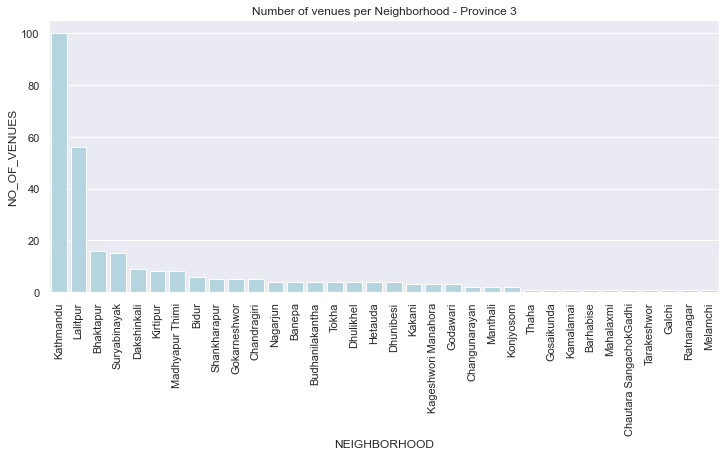

In [88]:
#Plot number of venues registered per neighborhood for PROVINCE 3
ax = sns.barplot(x='NEIGHBORHOOD',y='NO_OF_VENUES',data=venues_count.loc[venues_count.PROVINCE==3,:], color='lightblue')
ax.set_title('Number of venues per Neighborhood - Province 3')
ax.set_xticklabels(labels=venues_count.loc[venues_count.PROVINCE==3,:]['NEIGHBORHOOD'],rotation=90);

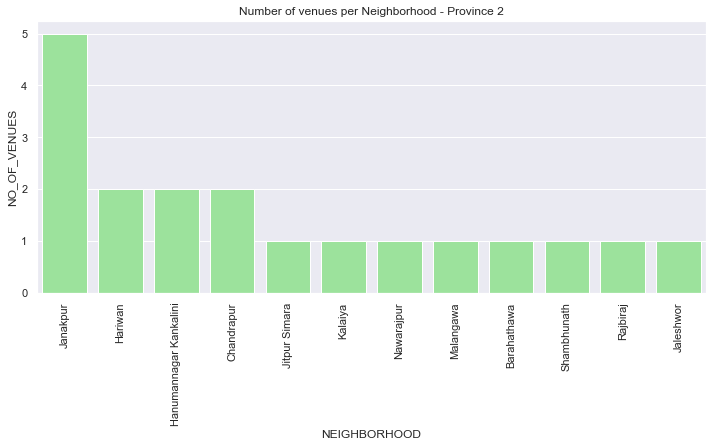

In [89]:
#Plot number of venues registered per neighborhood for PROVINCE 2
ax = sns.barplot(x='NEIGHBORHOOD',y='NO_OF_VENUES',data=venues_count.loc[venues_count.PROVINCE==2,:], color='lightgreen')
ax.set_title('Number of venues per Neighborhood - Province 2')
ax.set_xticklabels(labels=venues_count.loc[venues_count.PROVINCE==2,:]['NEIGHBORHOOD'],rotation=90);

Machine learning models don't understand words and so we will use pandas one-hot encoding to transform the venues in each neighborhood in binary terms with help of their venue categories, where 1 represent the venue category and 0 represents not the venue category. Understand that each row in dataframe below will be a venue and the value 1 will point towards its category.

In [90]:
#One hot encoding
venues_onehot = pd.get_dummies(venues.loc[:,'VENUE_CATEGORY'], prefix="", prefix_sep="")

In [91]:
venues_onehot.shape

(305, 95)

In [92]:
# Add the neighborhood column back to the dataframe
venues_onehot['NEIGHBORHOOD'] = venues['NEIGHBORHOOD']

In [93]:
venues_onehot.shape

(305, 96)

In [94]:
venues_onehot

,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Garden,Bistro,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,NEIGHBORHOOD
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Kamalamai
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Manthali
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Manthali
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Barhabise
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chautara SangachokGadhi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Malangawa
301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chandrapur
302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chandrapur
303,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Jitpur Simara


We will use the dataframe above for machine learning specifically KMeans clustering, but before that let us look at most common venue categories in some of the neighborhoods. In order to do that, we will first group above values by neighborhood and take a mean of groupby object, this will give the probability of finding the venue category in that neighborhood, in comparision to other venue categories. If it is difficult to understand let me explain with an example. Suppose there are 2 Asian Restaurants named 'A' and 'B' in a neighborhood and 1 Bakery named C. Our above data frame will have three rows representing each venue, as each row represents a venue, and not a venue category. Now, if we groupby neighborhood and calculate the mean of groupby object, it will calculate mean of Asian Restaurants as (1+1+0)/3 = 2/3 and Bakery as (0+1+0)/3=1/3. So the comparative probability of finding an asian restaurant in that neighborhood is greator than finding a Bakery.  If you still didn't understand it, no worries. You can skip the two tables below. It is just a side-note, not the main idea. The first 10 rows of above computation are shown below.

In [95]:
# Average per neighborhood
venues_grouped = venues_onehot.groupby(['NEIGHBORHOOD']).mean().reset_index()
venues_grouped.head(10)

,NEIGHBORHOOD,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Garden,...,Spanish Restaurant,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village
0,Banepa,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
1,Barahathawa,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
2,Barhabise,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
3,Bhaktapur,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0
4,Bidur,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0
5,Budhanilakantha,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
6,Chandragiri,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
7,Chandrapur,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
8,Changunarayan,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
9,Chautara SangachokGadhi,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0


In [96]:
print(venues_grouped.shape)

(46, 96)


Now, as we have comparative probalilities, we can sort venue ategories based on it, to determine most common ones for our neighborhoods, as shown below. We will determine the 10 most common venues in the neighborhood

In [97]:
# Borrow the function from the lab. Sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [98]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NEIGHBORHOOD']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create new dataframes
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['NEIGHBORHOOD'] = venues_grouped['NEIGHBORHOOD']

for i in np.arange(neighborhoods_venues_sorted.shape[0]):
    neighborhoods_venues_sorted.iloc[i, 1:] = return_most_common_venues(venues_grouped.iloc[i, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,NEIGHBORHOOD,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Banepa,Café,Fast Food Restaurant,Bus Station,Village,Diner,Eastern European Restaurant,Farm,Fish & Chips Shop,Food,Forest
1,Barahathawa,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
2,Barhabise,River,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
3,Bhaktapur,Hostel,Bus Station,Café,Plaza,Historic Site,Tree,Lake,Restaurant,Himalayan Restaurant,Indian Restaurant
4,Bidur,Indian Restaurant,Scenic Lookout,Vacation Rental,Restaurant,River,Village,Diner,Dumpling Restaurant,Eastern European Restaurant,Farm
5,Budhanilakantha,Resort,Athletics & Sports,Historic Site,Outdoors & Recreation,Village,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant
6,Chandragiri,Coffee Shop,Record Shop,Historic Site,Park,French Restaurant,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop
7,Chandrapur,Motel,Bus Station,Diner,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest,French Restaurant
8,Changunarayan,Resort,Department Store,Diner,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
9,Chautara SangachokGadhi,Soccer Field,Village,Garden,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest


In [99]:
#Add the basic neighborhood information
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted, prov)
neighborhoods_venues_sorted.head(3)

,NEIGHBORHOOD,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,LONGITUDE,LATITUDE
0,Banepa,Café,Fast Food Restaurant,Bus Station,Village,Diner,Eastern European Restaurant,Farm,Fish & Chips Shop,Food,Forest,3,KABHREPALANCHOK,Nagarpalika,85.515890,27.648074
1,Barahathawa,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest,2,SARLAHI,Nagarpalika,85.456055,26.981470
2,Barhabise,River,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest,3,SINDHUPALCHOK,Nagarpalika,85.902438,27.821514


we will change the order of columns, to better suit readability

In [100]:
#Reorder columns
columns = ['PROVINCE','DISTRICT','NEIGHBORHOOD','LONGITUDE','LATITUDE'] + neighborhoods_venues_sorted.columns[1:11].tolist()
columns

['PROVINCE',
 'DISTRICT',
 'NEIGHBORHOOD',
 'LONGITUDE',
 'LATITUDE',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

In [101]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.loc[:,columns]
neighborhoods_venues_sorted.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,KABHREPALANCHOK,Banepa,85.515890,27.648074,Café,Fast Food Restaurant,Bus Station,Village,Diner,Eastern European Restaurant,Farm,Fish & Chips Shop,Food,Forest
1,2,SARLAHI,Barahathawa,85.456055,26.981470,Bus Stop,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
2,3,SINDHUPALCHOK,Barhabise,85.902438,27.821514,River,Village,Department Store,Dumpling Restaurant,Eastern European Restaurant,Farm,Fast Food Restaurant,Fish & Chips Shop,Food,Forest
3,3,BHAKTAPUR,Bhaktapur,85.431881,27.674754,Hostel,Bus Station,Café,Plaza,Historic Site,Tree,Lake,Restaurant,Himalayan Restaurant,Indian Restaurant
4,3,NUWAKOT,Bidur,85.138304,27.925632,Indian Restaurant,Scenic Lookout,Vacation Rental,Restaurant,River,Village,Diner,Dumpling Restaurant,Eastern European Restaurant,Farm


## 4.4. Clustering Province 2 and Province 3 neighborhoods<a id='id-4-4'></a>

Here we will use machine learning algorithm KMeans clustering. We know that items belonging to a cluster are similar. We will use same principle to determine neighborhoods similar to kathmandu in province number 2.

In [102]:
# Import necessary libraries
import numpy as np 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 
from sklearn import preprocessing
%matplotlib inline

We will use proportion dataset for machine learning model KMeans clustering. 

In [103]:
venues_grouped.head()

,NEIGHBORHOOD,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Garden,...,Spanish Restaurant,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village
0,Banepa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
1,Barahathawa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
2,Barhabise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0
3,Bhaktapur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0
4,Bidur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0


In [104]:
k_means = KMeans(init = "k-means++", n_clusters = 10, n_init = 500, max_iter=500)

In [105]:
# Fit the model 
k_means.fit(venues_grouped.drop('NEIGHBORHOOD',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=10, n_init=500, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

We will save cluster information in the dataframe now

In [106]:
#Add the labels to the venues_grouped dataset
venues_grouped['CLUSTER']=k_means.labels_
venues_grouped.head()

,NEIGHBORHOOD,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Garden,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,Banepa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,7
1,Barahathawa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,5
2,Barhabise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,9
3,Bhaktapur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,7
4,Bidur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0,7


We will use this dataframe at the end

In [107]:
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted.loc[:,['PROVINCE','DISTRICT','NEIGHBORHOOD', 'LONGITUDE','LATITUDE']], venues_grouped)
neighborhoods_venues_sorted.head(3)

,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,3,KABHREPALANCHOK,Banepa,85.515890,27.648074,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,2,SARLAHI,Barahathawa,85.456055,26.981470,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,3,SINDHUPALCHOK,Barhabise,85.902438,27.821514,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


Now, our customer wishes to open the restaurant in a neighborhood similar to Kathmadu. Lets check on which cluster does that neighborhood kathmandu belongs.

In [108]:
neighborhoods_venues_sorted.groupby('CLUSTER').count().NEIGHBORHOOD

CLUSTER
0     3
1     8
2     2
3     3
4     1
5     2
6     1
7    24
8     1
9     1
Name: NEIGHBORHOOD, dtype: int64

In [109]:
target_cluster_df = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['NEIGHBORHOOD']=='Kathmandu',:]
target_cluster_df.reset_index(inplace=True, drop=True)
target_cluster = target_cluster_df.loc[0,'CLUSTER']
print('The target cluster is: {} '.format(target_cluster))
target_cluster_df.head()

The target cluster is: 7 


,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,3,KATHMANDU,Kathmandu,85.329528,27.708764,0.0,0.14,0.0,0.0,0.02,...,0.01,0.01,0.0,0.0,0.0,0.0,0.01,0.01,0.0,7


In [110]:
#Filter neighborhoods from Province 2 that belong to the target cluster
possible_neighborhoods = neighborhoods_venues_sorted[
    (neighborhoods_venues_sorted['CLUSTER']==target_cluster) &
    (neighborhoods_venues_sorted['PROVINCE']==2)]

print('There are {} neighborhoods in Province 2 with similar characteristics to Kathmandu'
      .format(possible_neighborhoods.shape[0]))

There are 6 neighborhoods in Province 2 with similar characteristics to Kathmandu


In [111]:
# Clean up index
possible_neighborhoods.reset_index(inplace=True, drop=True)

In [112]:
# Print the possible neighborhoods
possible_neighborhoods = possible_neighborhoods.loc[:,['DISTRICT','NEIGHBORHOOD']]
possible_neighborhoods

,DISTRICT,NEIGHBORHOOD
0,SAPTARI,Hanumannagar Kankalini
1,SARLAHI,Hariwan
2,DHANUSHA,Janakpur
3,BARA,Jitpur Simara
4,BARA,Kalaiya
5,SIRAHA,Nawarajpur


### 4.5. Neighborhood Ranking<a id='id-4-5'></a>

We now have a dataset containing a list of potential neighborhoods. Let us also find the top three among them

We will rank each neighborhood based on a composite ranking using the following items:

a. Total Population. Weight: 50%  
b. Average income per household within each neighborhood. Weight: 35%  
c. Amount of already existing Hotel. Weight: 15%

To create this ranking, lets first normalize each of the three metrics. The three metrics are measurement of non compatible items. Normalizing them we can add them together to calculate our ranking system with weights provided above.

Also, from here we will be focusing only on province number 2 datasets as our competing neighborhoods are from province number 2 only.

In [113]:
#we have
prov2_cord_popu_income.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD),POPULATION_NORMALIZED,INCOME_NORMALIZED
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790,27129,801.0,0.111145,0.541216
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204,21842,801.0,0.089485,0.541216
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306,23166,801.0,0.094909,0.541216
3,2,SAPTARI,Nagarpalika,Bode Barsain,86.573847,26.564128,43293,801.0,0.177368,0.541216
4,2,SAPTARI,Gaunpalika,Chhinnamasta,86.734078,26.461687,28437,801.0,0.116504,0.541216


In [114]:
max_popu = prov2_cord_popu_income['POPULATION'].max(axis=0)
max_income = prov2_cord_popu_income['PER CAPITA INCOME (USD)'].max(axis=0)

In [115]:
prov2_cord_popu_income['POPULATION_NORMALIZED'] = prov2_cord_popu_income['POPULATION']/max_popu
prov2_cord_popu_income['INCOME_NORMALIZED'] = prov2_cord_popu_income['PER CAPITA INCOME (USD)']/max_income
prov2_cord_popu_income.head(3)

,PROVINCE,DISTRICT,NEIGHBORHOOD_TYPE,NEIGHBORHOOD,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD),POPULATION_NORMALIZED,INCOME_NORMALIZED
0,2,SAPTARI,Gaunpalika,Agnisair Krishna Savaran,86.796975,26.646790,27129,801.0,0.111145,0.541216
1,2,SAPTARI,Gaunpalika,Balan Bihul,86.522056,26.571204,21842,801.0,0.089485,0.541216
2,2,SAPTARI,Gaunpalika,Bishnupur_saptari,86.720324,26.518306,23166,801.0,0.094909,0.541216


In [116]:
venues_grouped.columns

Index(['NEIGHBORHOOD', 'Airport', 'Asian Restaurant', 'Athletics & Sports',
       'BBQ Joint', 'Bakery', 'Bar', 'Basketball Court', 'Bed & Breakfast',
       'Beer Garden', 'Bistro', 'Breakfast Spot', 'Buddhist Temple',
       'Burger Joint', 'Bus Station', 'Bus Stop', 'Business Service', 'Café',
       'Campground', 'Chinese Restaurant', 'City', 'Clothing Store',
       'Coffee Shop', 'Cuban Restaurant', 'Department Store', 'Diner',
       'Dumpling Restaurant', 'Eastern European Restaurant', 'Farm',
       'Fast Food Restaurant', 'Fish & Chips Shop', 'Food', 'Forest',
       'French Restaurant', 'Fried Chicken Joint', 'Garden', 'Gastropub',
       'German Restaurant', 'Golf Course', 'Gym', 'Halal Restaurant',
       'Harbor / Marina', 'Himalayan Restaurant', 'Historic Site',
       'History Museum', 'Hookah Bar', 'Hostel', 'Hotel', 'Hotel Bar',
       'Ice Cream Shop', 'Indian Restaurant', 'Intersection',
       'Italian Restaurant', 'Japanese Restaurant', 'Lake', 'Laser Tag',
     

In [117]:
neighborhoods_venues_sorted.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,3,KABHREPALANCHOK,Banepa,85.515890,27.648074,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,7
1,2,SARLAHI,Barahathawa,85.456055,26.981470,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,5
2,3,SINDHUPALCHOK,Barhabise,85.902438,27.821514,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,9
3,3,BHAKTAPUR,Bhaktapur,85.431881,27.674754,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,7
4,3,NUWAKOT,Bidur,85.138304,27.925632,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0,7


In [118]:
#Based on section 3.2 
prov2_hotel = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted.PROVINCE==2, :].reset_index(drop=True)
prov2_hotel.head()

,PROVINCE,DISTRICT,NEIGHBORHOOD,LONGITUDE,LATITUDE,Airport,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Steakhouse,Theme Park Ride / Attraction,Trail,Train Station,Tree,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Village,CLUSTER
0,2,SARLAHI,Barahathawa,85.456055,26.981470,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2,RAUTAHAT,Chandrapur,85.370446,27.138608,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,2,SAPTARI,Hanumannagar Kankalini,86.878736,26.512161,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,2,SARLAHI,Hariwan,85.576516,27.100324,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4,2,MAHOTTARI,Jaleshwor,85.801918,26.646348,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [119]:
prov2_hotel = prov2_hotel.loc[:, ['NEIGHBORHOOD','Hotel']]
prov2_hotel.rename(columns={"Hotel": "NUMBER OF HOTELS"}, inplace=True)
prov2_hotel.head()

,NEIGHBORHOOD,NUMBER OF HOTELS
0,Barahathawa,0.0
1,Chandrapur,0.0
2,Hanumannagar Kankalini,0.0
3,Hariwan,0.0
4,Jaleshwor,0.0


In [120]:
#"Normalize" and invert. This way, if a row is 1 then it means there are no hotels
prov2_hotel['BAR NUMBER OF HOTELS'] = 1-(prov2_hotel.loc[:,'NUMBER OF HOTELS']/prov2_hotel['NUMBER OF HOTELS'].max(axis=0))
prov2_hotel.head(10)

,NEIGHBORHOOD,NUMBER OF HOTELS,BAR NUMBER OF HOTELS
0,Barahathawa,0.0,1.0
1,Chandrapur,0.0,1.0
2,Hanumannagar Kankalini,0.0,1.0
3,Hariwan,0.0,1.0
4,Jaleshwor,0.0,1.0
5,Janakpur,0.4,0.6
6,Jitpur Simara,0.0,1.0
7,Kalaiya,0.0,1.0
8,Malangawa,0.0,1.0
9,Nawarajpur,0.0,1.0


In [121]:
possible_neighborhoods = pd.merge(possible_neighborhoods.loc[:,['DISTRICT','NEIGHBORHOOD']],prov2_cord_popu_income)
possible_neighborhoods = pd.merge(possible_neighborhoods,prov2_hotel)
possible_neighborhoods.head()

,DISTRICT,NEIGHBORHOOD,PROVINCE,NEIGHBORHOOD_TYPE,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD),POPULATION_NORMALIZED,INCOME_NORMALIZED,NUMBER OF HOTELS,BAR NUMBER OF HOTELS
0,SAPTARI,Hanumannagar Kankalini,2,Nagarpalika,86.878736,26.512161,45840,801.0,0.187803,0.541216,0.0,1.0
1,SARLAHI,Hariwan,2,Nagarpalika,85.576516,27.100324,43924,809.0,0.179953,0.546622,0.0,1.0
2,DHANUSHA,Janakpur,2,Upamahanagarpalika,85.936686,26.725416,162842,938.0,0.667150,0.633784,0.4,0.6
3,BARA,Jitpur Simara,2,Upamahanagarpalika,85.010673,27.200295,118398,1480.0,0.485067,1.000000,0.0,1.0
4,BARA,Kalaiya,2,Upamahanagarpalika,85.011567,27.028639,123363,1480.0,0.505408,1.000000,0.0,1.0


In [127]:
possible_neighborhoods

,DISTRICT,NEIGHBORHOOD,PROVINCE,NEIGHBORHOOD_TYPE,LONGITUDE,LATITUDE,POPULATION,PER CAPITA INCOME (USD),POPULATION_NORMALIZED,INCOME_NORMALIZED,NUMBER OF HOTELS,BAR NUMBER OF HOTELS,RANKING
0,SAPTARI,Hanumannagar Kankalini,2,Nagarpalika,86.878736,26.512161,45840,801.0,0.187803,0.541216,0.0,1.0,0.433327
1,SARLAHI,Hariwan,2,Nagarpalika,85.576516,27.100324,43924,809.0,0.179953,0.546622,0.0,1.0,0.431294
2,DHANUSHA,Janakpur,2,Upamahanagarpalika,85.936686,26.725416,162842,938.0,0.667150,0.633784,0.4,0.6,0.645399
3,BARA,Jitpur Simara,2,Upamahanagarpalika,85.010673,27.200295,118398,1480.0,0.485067,1.000000,0.0,1.0,0.742533
4,BARA,Kalaiya,2,Upamahanagarpalika,85.011567,27.028639,123363,1480.0,0.505408,1.000000,0.0,1.0,0.752704
5,SIRAHA,Nawarajpur,2,Gaunpalika,86.435139,26.607590,19056,689.0,0.078071,0.465541,0.0,1.0,0.351975


In [123]:
possible_neighborhoods['RANKING'] = possible_neighborhoods['POPULATION_NORMALIZED'] * 0.5 + possible_neighborhoods['INCOME_NORMALIZED'] * 0.35 + possible_neighborhoods['BAR NUMBER OF HOTELS'] * 0.15
recommended_neighborhoods = possible_neighborhoods.sort_values(by='RANKING',ascending=False)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

In [124]:
recommended_neighborhoods = recommended_neighborhoods.loc[:,['DISTRICT','NEIGHBORHOOD','RANKING', 'LONGITUDE', 'LATITUDE']]

## 5. Results<a id='results'></a>

Our ranking syatem based on the weights we provided to Population of the neighborhood, Income of the neighborhood and existing number of hotels provided three neighborhoods along with there locations, as shown below.

In [125]:
recommended_neighborhoods.head(3)

,DISTRICT,NEIGHBORHOOD,RANKING,LONGITUDE,LATITUDE
0,BARA,Kalaiya,0.752704,85.011567,27.028639
1,BARA,Jitpur Simara,0.742533,85.010673,27.200295
2,DHANUSHA,Janakpur,0.645399,85.936686,26.725416


For the clustering process we picket a large number of cluster (K=10), nevertheless most of the neighborhoods fell into one cluster, as shown below.

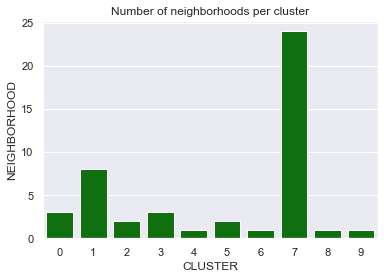

In [126]:
venues_grouped_count = venues_grouped.groupby('CLUSTER')['NEIGHBORHOOD'].count().to_frame()
venues_grouped_count.reset_index(inplace=True)
ax = sns.barplot(x='CLUSTER', y='NEIGHBORHOOD', data=venues_grouped_count, color='green')
ax.set_title('Number of neighborhoods per cluster');

## 6. Discussion<a id='discussion'></a>

After performing a clustering analysis, a group of possible neighborhoods,  with similar characteristics to the target neighborhood from Province 3, were identified. We decided to filter further our results based on the potential customer base (Population), spending power of the population (income), and the number of competitors. We came up with the three most suitable locations based on available data.

It is necessary to address the difference in data available between province two and province 3, and the bias generated because of it. There may be a perfect reason for the small number of hotels in any of those areas, logic which would make them unsuitable for a new restaurant regardless of lack of competition in the area. It is also necessary to point out that, hyperparameters tuning and comparison between alternative models(KMeans, DBSCAN) we not part of this analysis. KMeans, with its defects like having no concept of outliers, and other models with there own shortcomings may not provide full-proof results.

## 7. Conclusion<a id='conclusion'></a>

The purpose of this analysis was only to provide info on areas similar to Kathmandu in province 2 with the available information, not crowded with existing hotels, and amidst many people with higher spending power.  Recommended zones should, therefore, be considered only as a starting point for more detailed analysis, which could eventually result in a location that has not only no nearby competition but also other factors taken into account and all other relevant conditions met. Domain knowledge and field evaluation are inseparable from data analysis.

Final decission on optimal hotel location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.